# Setup

In [ ]:
import itertools
import os
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.15.0
Hub version: 0.16.1
GPU is available


# Set up dataset

Inputs are suitably resized for the selected module. Dataset augmentation (i.e., random distortions of an image each time it is read) improves training, esp. when fine-tuning.

In [ ]:
#mounting google drive
from google.colab import drive
import shutil
import glob
import re
import random

drive.mount("/content/drive", force_remount=True)
src_dir = '/content/drive/MyDrive/fire_dataset'

Mounted at /content/drive


In [ ]:
from sklearn.model_selection import train_test_split
import os
import shutil
import random
from google.colab import drive


# Define the directory paths
fire_images_dir = '/content/drive/MyDrive/fire_new_dataset/fire_images'
non_fire_images_dir = '/content/drive/MyDrive/fire_new_dataset/non_fire_images'


# List files in the fire_images directory
fire_images_files = os.listdir(fire_images_dir)


# List files in the non_fire_images directory
non_fire_images_files = os.listdir(non_fire_images_dir)

# Print the number of files in each directory
print(f"Number of files in fire_images directory: {len(fire_images_files)}")
print(f"Number of files in non_fire_images directory: {len(non_fire_images_files)}")
print()

# Remove the ".png" extension from image filenames
fire_images_files = [file.rsplit('.', 1)[0] for file in fire_images_files]
non_fire_images_files = [file.rsplit('.', 1)[0] for file in non_fire_images_files]

# Define labels for fire and non-fire images
fire_labels = [file.rsplit('.', 1)[0] for file in fire_images_files]
non_fire_labels = [file.rsplit('.', 1)[0] for file in non_fire_images_files]

# Split training data for fire and non-fire images separately
train_fire_images, test_fire_images, train_fire_labels, test_fire_labels = train_test_split(fire_images_files, fire_labels, test_size=0.2, random_state=42)
train_non_fire_images, test_non_fire_images, train_non_fire_labels, test_non_fire_labels = train_test_split(non_fire_images_files, non_fire_labels, test_size=0.2, random_state=42)

# Split testing/validation data for fire and non-fire images separately
test_fire_images, val_fire_images, test_fire_labels, val_fire_labels = train_test_split(test_fire_images, test_fire_labels, test_size=0.5, random_state=42)
test_non_fire_images, val_non_fire_images, test_non_fire_labels, val_non_fire_labels = train_test_split(test_non_fire_images, test_non_fire_labels, test_size=0.5, random_state=42)

# Combine the datasets
train_images = train_fire_images + train_non_fire_images
test_images = test_fire_images + test_non_fire_images
val_images = val_fire_images + val_non_fire_images
train_labels = train_fire_labels + train_non_fire_labels
test_labels = test_fire_labels + test_non_fire_labels
val_labels = val_fire_labels + val_non_fire_labels

# Print the sizes of training and testing sets
print(f"Number of training samples for fire data: {len(train_fire_images)}")
print(f"Number of testing samples for fire data: {len(test_fire_images)}")
print(f"Number of validation samples for fire data: {len(val_fire_labels)}")
print(f"Number of training samples for non-fire data: {len(train_non_fire_images)}")
print(f"Number of testing samples for non-fire data: {len(test_non_fire_images)}")
print(f"Number of validation samples for non-fire data: {len(val_non_fire_labels)}")
print()

# Print the sizes of training and testing sets
print(f"Number of training samples: {len(train_images)}")
print(f"Number of testing samples: {len(test_images)}")
print(f"Number of validation samples: {len(val_images)}")
print()

# Print the first few samples in each set
print("Training samples:")
print(train_images[:5])
print(train_labels[:5])
print(train_images[-5:])
print(train_labels[-5:])
print("Testing samples:")
print(test_images[:5])
print(test_labels[:5])
print(test_images[-5:])
print(test_labels[-5:])
print("Validation samples:")
print(val_images[:5])
print(val_images[:5])
print(val_images[-5:])
print(val_images[-5:])
print()

class_names = ['fire', 'non_fire']

# Define function to copy images to directories
def copy_images_to_directory(image_list, label_list, destination_dir, source_dir):
     # Create fire and non-fire subdirectories
    fire_dir = os.path.join(destination_dir, 'fire')
    non_fire_dir = os.path.join(destination_dir, 'non_fire')
    os.makedirs(fire_dir, exist_ok=True)
    os.makedirs(non_fire_dir, exist_ok=True)

    for image_name, label in zip(image_list, label_list):
        # Determine the destination directory based on the label
        if label == 'fire':
            label_dir = fire_dir
        else:
            label_dir = non_fire_dir
        # Check if the file already exists in the destination directory
        destination_file_path = os.path.join(label_dir, image_name + '.png')
        if not os.path.exists(destination_file_path):
            # Copy image to corresponding directory
            source_file_path = os.path.join(source_dir, image_name + '.png')
            shutil.copy(source_file_path, destination_file_path)
            print(str(label_dir) + ": Images added")
        else:
            print(str(label_dir) + ": Up to date")
            break

# Define directories for training, testing, and validation sets
train_dir = '/content/drive/MyDrive/fire_new_dataset/train'
test_dir = '/content/drive/MyDrive/fire_new_dataset/test'
val_dir = '/content/drive/MyDrive/fire_new_dataset/val'

# Define source directories for fire and non-fire images
fire_source_dir = '/content/drive/MyDrive/fire_new_dataset/fire_images'
non_fire_source_dir = '/content/drive/MyDrive/fire_new_dataset/non_fire_images'

# Copy fire images to training directory
copy_images_to_directory(train_fire_images, train_fire_labels, train_dir, fire_source_dir)

# Copy non-fire images to training directory
copy_images_to_directory(train_non_fire_images, train_non_fire_labels, train_dir, non_fire_source_dir)

# Copy fire images to testing directory
copy_images_to_directory(test_fire_images, test_fire_labels, test_dir, fire_source_dir)

# Copy non-fire images to testing directory
copy_images_to_directory(test_non_fire_images, test_non_fire_labels, test_dir, non_fire_source_dir)

# Copy fire images to validation directory
copy_images_to_directory(val_fire_images, val_fire_labels, val_dir, fire_source_dir)

# Copy non-fire images to validation directory
copy_images_to_directory(val_non_fire_images, val_non_fire_labels, val_dir, non_fire_source_dir)


Number of files in fire_images directory: 755
Number of files in non_fire_images directory: 755

Number of training samples for fire data: 604
Number of testing samples for fire data: 75
Number of validation samples for fire data: 76
Number of training samples for non-fire data: 604
Number of testing samples for non-fire data: 75
Number of validation samples for non-fire data: 76

Number of training samples: 1208
Number of testing samples: 150
Number of validation samples: 152

Training samples:
['fire.11', 'fire.345', 'fire.310', 'fire.108', 'fire.141']
['fire', 'fire', 'fire', 'fire', 'fire']
['non_fire.164', 'non_fire.196', 'abc279', 'nofire_0042', 'non_fire.207']
['non_fire', 'non_fire', 'abc279', 'nofire_0042', 'non_fire']
Testing samples:
['fire.463', 'fire.196', 'fire.289', 'fire.690', 'fire.730']
['fire', 'fire', 'fire', 'fire', 'fire']
['nofire_0096', 'nofire_0148', 'non_fire.68', 'non_fire.35', 'non_fire.93']
['nofire_0096', 'nofire_0148', 'non_fire', 'non_fire', 'non_fire']


# Inception-ResNetV2 Model

## Data Preprocessing

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE = (299, 299)
BATCH_SIZE = 32

# Define image data generators
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
        val_dir,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary')

Found 1204 images belonging to 2 classes.
Found 171 images belonging to 2 classes.
Found 155 images belonging to 2 classes.


## Data Visualization

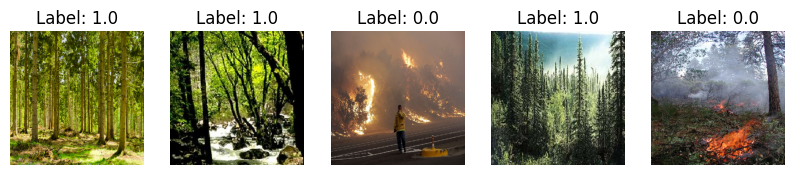

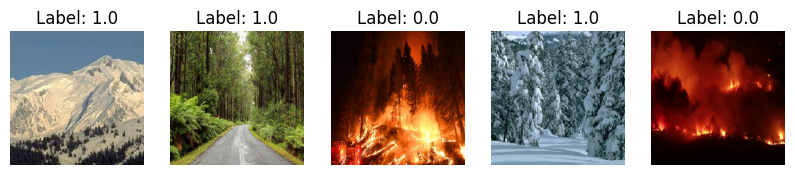

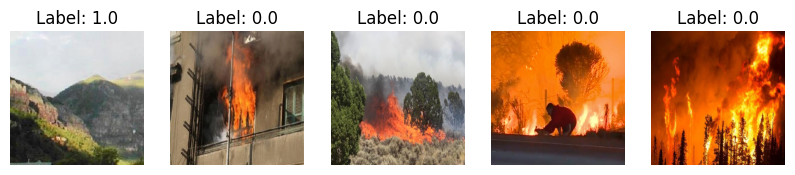

In [ ]:
import matplotlib.pyplot as plt

# Function to plot 5 images from a generator
def plot_images(generator, num_images=5):
    # Get a batch of images and labels
    images, labels = next(generator)

    # Plot the images
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i])
        plt.title('Label: {}'.format(labels[i]))
        plt.axis('off')
    plt.show()

# Plot images from the training generator
plot_images(train_generator)

# Plot images from the test generator
plot_images(test_generator)

# Plot images from the validation generator
plot_images(validation_generator)


## Training the Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.optimizers import Adam

# Load Inception-ResNetV2 model
pretrained_base = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Transfer Learning Setup
model = Sequential([
    pretrained_base,
    Flatten(),
    tf.keras.layers.Dropout(0.5),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Freeze the pretrained layers
pretrained_base.trainable = False

# define callback
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=train_dir)

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=5,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[tensorboard_callback]
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Save the model
model.save('inception_resnetv2_model.tf')


219055592/219055592 [==============================] - 1s 0us/step
Epoch 1/5
38/38 [==============================] - 249s 6s/step - loss: 0.5756 - accuracy: 0.9078 - val_loss: 0.4526 - val_accuracy: 0.9298
Epoch 2/5
38/38 [==============================] - 26s 675ms/step - loss: 0.0832 - accuracy: 0.9826 - val_loss: 0.3243 - val_accuracy: 0.9708
Epoch 3/5
38/38 [==============================] - 25s 649ms/step - loss: 0.0069 - accuracy: 0.9967 - val_loss: 0.2888 - val_accuracy: 0.9649
Epoch 4/5
38/38 [==============================] - 26s 668ms/step - loss: 0.0058 - accuracy: 0.9967 - val_loss: 0.2801 - val_accuracy: 0.9708
Epoch 5/5
5/5 [==============================] - 37s 9s/step - loss: 0.2456 - accuracy: 0.9806
Test Loss: 0.24557970464229584
Test Accuracy: 0.9806451797485352


## Load the Model

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

import tensorflow as tf

# Load model
model = load_model('/content/inception_resnetv2_model.tf')

# Now the model is ready for predictions or evaluations


## Using the Model

In [ ]:
import os
import cv2
import numpy as np

# Define the directory containing subdirectories of images
directory = '/content/drive/MyDrive/Extra_Test_Images'

# Initialize counts for fire and non-fire images
fire_count = 0
non_fire_count = 0

# Iterate through each subdirectory (assuming each subdirectory contains images)
for root, dirs, files in os.walk(directory):
    for dir in dirs:
        # Get the path to the current subdirectory
        subdirectory = os.path.join(root, dir)

        # Get a list of all image files in the subdirectory
        image_files = [f for f in os.listdir(subdirectory)]

        # Iterate through each image file in the subdirectory
        for image_file in image_files:
            # Define the path to the image
            image_path = os.path.join(subdirectory, image_file)

            # Load and preprocess the image
            img = cv2.imread(image_path)
            img = cv2.resize(img, (299, 299))
            img = img / 255.0  # Rescale pixel values
            img = np.expand_dims(img, axis=0)  # Add batch dimension

            # Perform prediction
            prediction = model.predict(img, verbose=0)

            # Interpret the prediction result
            if prediction[0] < 0.5:
                print(f"The image '{image_file}' in '{dir}' contains fire.")
                fire_count += 1
            else:
                print(f"The image '{image_file}' in '{dir}' does not contain fire.")
                non_fire_count += 1

# Print the counts
print(f"Number of images containing fire: {fire_count}")
print(f"Number of images not containing fire: {non_fire_count}")


The image 'testfire3.png' in 'fire_images' contains fire.
The image 'testfire4.png' in 'fire_images' does not contain fire.
The image 'testfire5.png' in 'fire_images' contains fire.
The image 'testfire7.png' in 'fire_images' contains fire.
The image 'testfire8.png' in 'fire_images' contains fire.
The image 'testfire9.png' in 'fire_images' does not contain fire.
The image 'testfire10.png' in 'fire_images' contains fire.
The image 'testfire.png' in 'fire_images' contains fire.
The image 'testfire2.png' in 'fire_images' contains fire.
The image 'testfire6.png' in 'fire_images' contains fire.
The image 'candle.png' in 'non_fire_images' contains fire.
The image 'fog.png' in 'non_fire_images' does not contain fire.
The image 'tvfire.png' in 'non_fire_images' does not contain fire.
The image 'sunset.png' in 'non_fire_images' does not contain fire.
The image 'stopsign.png' in 'non_fire_images' does not contain fire.
The image 'barbequegrill.png' in 'non_fire_images' contains fire.
The image 'c

## Confusion Matrix

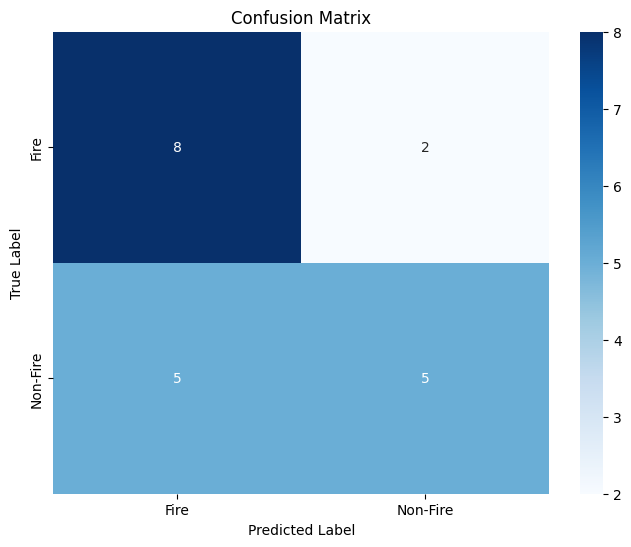

In [ ]:
import cv2
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define the directory containing subdirectories of images
directory = '/content/drive/MyDrive/Extra_Test_Images'

# Initialize lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Define a dictionary to map each directory to its corresponding label
directory_labels = {
    "fire_images": 0,       # Label for images in "fire_images" directory
    "non_fire_images": 1   # Label for images in "non_fire_images" directory
}

# Iterate through each subdirectory (assuming each subdirectory contains images)
for root, dirs, files in os.walk(directory):
    for dir in dirs:
        # Get the path to the current subdirectory
        subdirectory = os.path.join(root, dir)

        # Get a list of all image files in the subdirectory
        image_files = [f for f in os.listdir(subdirectory)]

        # Iterate through each image file in the subdirectory
        for image_file in image_files:
            # Define the path to the image
            image_path = os.path.join(subdirectory, image_file)

            # Load and preprocess the image
            img = cv2.imread(image_path)
            img = cv2.resize(img, (299, 299))
            img = img / 255.0  # Rescale pixel values
            img = np.expand_dims(img, axis=0)  # Add batch dimension

            # Perform prediction
            prediction = model.predict(img, verbose=0)

            # Interpret the prediction result
            predicted_label = 1 if prediction[0] > 0.5 else 0
            predicted_labels.append(predicted_label)

            # Extract true label based on the directory name
            true_label = directory_labels[dir]
            true_labels.append(true_label)

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=["Fire", "Non-Fire"], yticklabels=["Fire", "Non-Fire"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
